# Recognizing Landmarks on Columbia’s Campus


In [0]:
# importing the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Part 1

### 1.1 Downloading the mini-flowers dataset and classify given images using transfer learning.

In [0]:
# dowloading the dataset
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip -O /tmp/mini_flowers.zip

--2019-03-05 00:05:40--  https://storage.googleapis.com/applied-dl/mini_flowers.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40110537 (38M) [application/zip]
Saving to: ‘/tmp/mini_flowers.zip’

/tmp/mini_flowers.z 100%[===================>]  38.25M  74.7MB/s    in 0.5s    

2019-03-05 00:05:41 (74.7 MB/s) - ‘/tmp/mini_flowers.zip’ saved [40110537/40110537]



In [0]:
# working with the downloaded zip
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# checking the structure
!ls /tmp/train

daisy  dandelion  roses  sunflowers  tulips


In [0]:
# setting up directory paths
base_dir = '/tmp'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_daisy_dir = os.path.join(train_dir, 'daisy')
train_dandelion_dir = os.path.join(train_dir, 'dandelion')
train_roses_dir = os.path.join(train_dir, 'roses')
train_sunflowers_dir = os.path.join(train_dir, 'sunflowers')
train_tulips_dir = os.path.join(train_dir, 'tulips')
validation_daisy_dir = os.path.join(validation_dir, 'daisy')
validation_dandelion_dir = os.path.join(validation_dir, 'dandelion')
validation_roses_dir = os.path.join(validation_dir, 'roses')
validation_sunflowers_dir = os.path.join(validation_dir, 'sunflowers')
validation_tulips_dir = os.path.join(validation_dir, 'tulips')

In [0]:
# exploring the dataset and calculating lenghs
num_daisy_tr = len(os.listdir(train_daisy_dir))
num_dandelion_tr = len(os.listdir(train_dandelion_dir))
num_roses_tr = len(os.listdir(train_roses_dir))
num_sunflowers_tr = len(os.listdir(train_sunflowers_dir))
num_tulips_tr = len(os.listdir(train_tulips_dir))

num_daisy_val = len(os.listdir(validation_daisy_dir))
num_dandelion_val = len(os.listdir(validation_dandelion_dir))
num_roses_val = len(os.listdir(validation_roses_dir))
num_sunflowers_val = len(os.listdir(validation_sunflowers_dir))
num_tulips_val = len(os.listdir(validation_tulips_dir))

total_train = num_daisy_tr + num_dandelion_tr + num_roses_tr + num_sunflowers_tr + num_tulips_tr
total_val = num_daisy_val + num_dandelion_val + num_roses_val + num_sunflowers_val + num_tulips_val

In [0]:
# looking at the resulting values
print('Training daisy images:', num_daisy_tr)
print('Training dandelion images:', num_dandelion_tr)
print('Training roses images:', num_roses_tr)
print('Training sunflowers images:', num_sunflowers_tr)
print('Training tulips images:', num_tulips_tr)

print('Validation daisy images:', num_daisy_val)
print('Validation dandelion images:', num_dandelion_val)
print('Validation roses images:', num_roses_val)
print('Validation sunflowers images:', num_sunflowers_val)
print('Validation tulips images:', num_tulips_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training daisy images: 200
Training dandelion images: 200
Training roses images: 200
Training sunflowers images: 200
Training tulips images: 200
Validation daisy images: 100
Validation dandelion images: 100
Validation roses images: 100
Validation sunflowers images: 100
Validation tulips images: 100
--
Total training images: 1000
Total validation images: 500


In [0]:
# rescaling images (following the notes from the given notebooks)
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [0]:
# rescaling the images
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
# generating training data with labels
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, # Best practice: shuffle the training data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='categorical')

Found 1000 images belonging to 5 classes.


In [0]:
# generating validation data with labels
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='categorical')

Found 500 images belonging to 5 classes.


In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

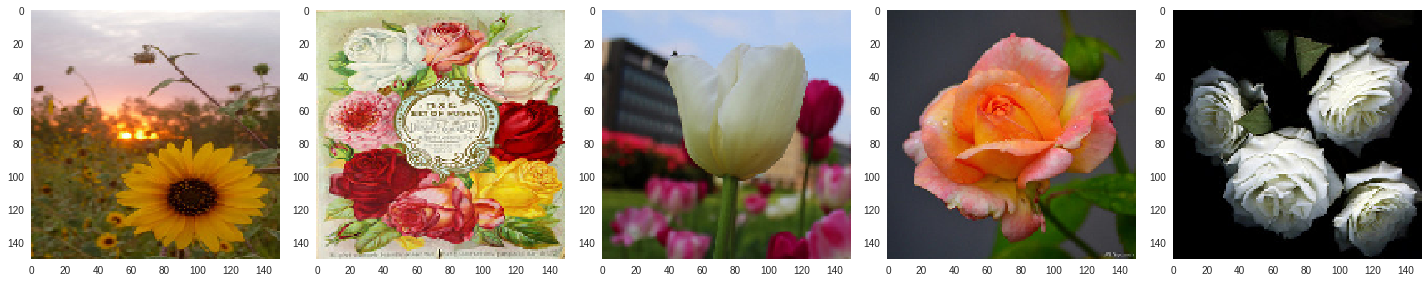

In [0]:
plotImages(sample_training_images[10:15])

#### Creating the model

In [0]:
# using knowledge sharing model
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# outputting the architecture of VGG16
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Applying the caching trick in building the model

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 5)) # changing this to work with a categorical view
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
# flattening base don the VGG16 requirements

FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))

In [0]:
# running the model on train and validation
EPOCHS = 50

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop', # tried with adam and a few others optimizers as well
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 0s 487us/sample - loss: 2.2075 - acc: 0.4420 - val_loss: 0.9612 - val_acc: 0.5960
Epoch 2/50
1000/1000 [==============================] - 0s 271us/sample - loss: 0.9229 - acc: 0.6330 - val_loss: 1.0416 - val_acc: 0.5980
Epoch 3/50
1000/1000 [==============================] - 0s 273us/sample - loss: 0.7581 - acc: 0.7180 - val_loss: 0.7961 - val_acc: 0.7060
Epoch 4/50
1000/1000 [==============================] - 0s 265us/sample - loss: 0.6251 - acc: 0.7550 - val_loss: 1.0887 - val_acc: 0.5920
Epoch 5/50
1000/1000 [==============================] - 0s 268us/sample - loss: 0.5371 - acc: 0.8200 - val_loss: 0.5994 - val_acc: 0.7740
Epoch 6/50
1000/1000 [==============================] - 0s 275us/sample - loss: 0.4178 - acc: 0.8560 - val_loss: 0.6167 - val_acc: 0.7840
Epoch 7/50
1000/1000 [==============================] - 0s 283us/sample - loss: 0.3265 - acc: 0.8910 - val_loss: 0.7054 - val

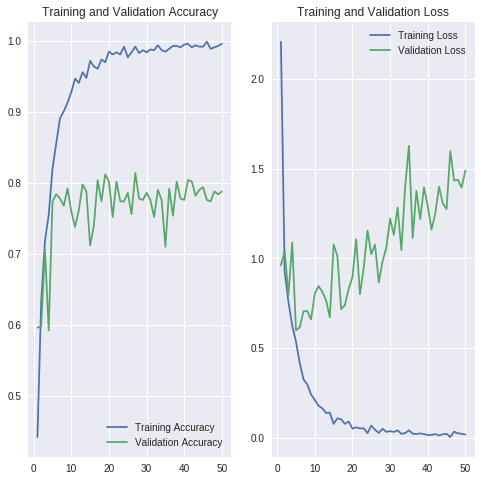

In [0]:
# visualizing the results
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Looking at the graphs above, there seems to be a steady performance around 80% validation accuracy for a number of different optimizers tested. More importantly, the model seem to have overfitten on the train dataset rather quickly. Therefore, I will also apply the image augmentation approach to see if maybe we can increase that benchmark.

#### Trying an alternative approach of image augmentation (per the tutorial guidance)

In [0]:
# trying an alternative approach
model_new = Sequential()
model_new.add(conv_base)
model_new.add(Flatten())
model_new.add(Dense(512, activation='relu'))
model_new.add(Dense(5, activation='softmax'))

In [0]:
conv_base.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
model_new.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Now is a good time for a cup of coffee
history_new = model_new.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 3s 196ms/step - loss: 10.2892 - acc: 0.2440
 - 11s - loss: 11.4484 - acc: 0.2120 - val_loss: 10.2892 - val_acc: 0.2440
Epoch 2/50
16/16 [==============================] - 3s 171ms/step - loss: 1.0866 - acc: 0.5680
 - 10s - loss: 5.7764 - acc: 0.3890 - val_loss: 1.0866 - val_acc: 0.5680
Epoch 3/50
16/16 [==============================] - 3s 170ms/step - loss: 1.9787 - acc: 0.4760
 - 10s - loss: 1.1356 - acc: 0.5980 - val_loss: 1.9787 - val_acc: 0.4760
Epoch 4/50
16/16 [==============================] - 3s 170ms/step - loss: 1.0550 - acc: 0.6260
 - 10s - loss: 0.9632 - acc: 0.6650 - val_loss: 1.0550 - val_acc: 0.6260
Epoch 5/50
16/16 [==============================] - 3s 174ms/step - loss: 0.7222 - acc: 0.7200
 - 10s - loss: 0.8215 - acc: 0.6830 - val_loss: 0.7222 - val_acc: 0.7200
Epoch 6/50
16/16 [==============================] - 3s 169ms/step - loss: 0.6961 - acc: 0.7340
 - 10s - loss: 0.7787 - acc: 0.7150 - val_loss: 0.6961 - val_a

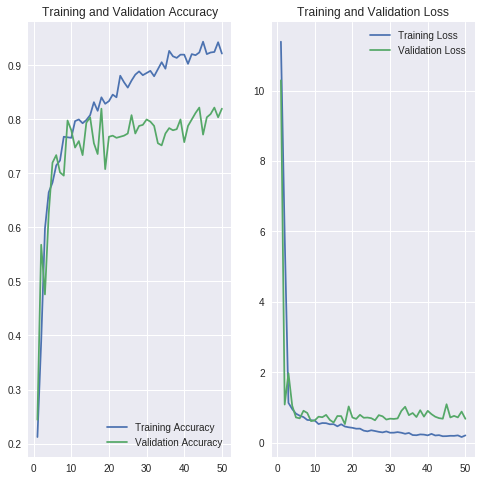

In [0]:
acc = history_new.history['acc']
val_acc = history_new.history['val_acc']

loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Similarly to the tutorial, the change in accuracy we were able to gain is not very strong. Before we saw accuracy somewhere around 80% while now it is up to approximately 82%. Nonetheless, the training accuracy no longer drastically overfits to 100% before we reach 50 epochs.

### 1.2 Running experiments using at least two pretrained convolutional bases

I thought it might be most applicable to choose to work with inception as another pretrained model in attempting to improve our results (similarly to VGG16, it was preptrained on imagenet).

#### Working with inception

In [0]:
# importing the model
inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

87916544/87910968 [==============================] - 3s 0us/step


In [0]:
# setting up the model
model_inception = Sequential()
model_inception.add(inception)
model_inception.add(Flatten())
model_inception.add(Dense(512, activation='relu'))
model_inception.add(Dense(5, activation='softmax'))

In [0]:
inception.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') # I ended up silencing image augmentation due to slow processing and not much gain from it

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
model_inception.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now is a good time for a cup of coffee
history_inception = model_inception.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 4s 278ms/step - loss: 9.9314 - acc: 0.3140
 - 14s - loss: 10.2954 - acc: 0.2430 - val_loss: 9.9314 - val_acc: 0.3140
Epoch 2/50
16/16 [==============================] - 3s 167ms/step - loss: 3.2237 - acc: 0.5300
 - 10s - loss: 4.6254 - acc: 0.4260 - val_loss: 3.2237 - val_acc: 0.5300
Epoch 3/50
16/16 [==============================] - 3s 159ms/step - loss: 1.9413 - acc: 0.6640
 - 10s - loss: 1.6128 - acc: 0.6380 - val_loss: 1.9413 - val_acc: 0.6640
Epoch 4/50
16/16 [==============================] - 3s 157ms/step - loss: 1.0173 - acc: 0.7220
 - 10s - loss: 1.3307 - acc: 0.6680 - val_loss: 1.0173 - val_acc: 0.7220
Epoch 5/50
16/16 [==============================] - 2s 156ms/step - loss: 1.1313 - acc: 0.7140
 - 10s - loss: 0.9499 - acc: 0.7190 - val_loss: 1.1313 - val_acc: 0.7140
Epoch 6/50
16/16 [==============================] - 3s 157ms/step - loss: 1.0896 - acc: 0.7240
 - 10s - loss: 0.9684 - acc: 0.7110 - val_loss: 1.0896 - val_acc

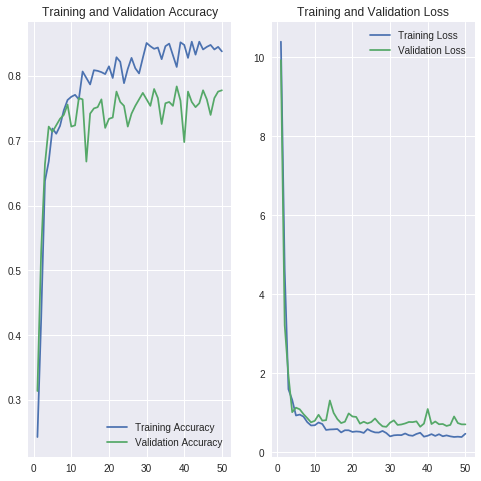

In [0]:
acc = history_inception.history['acc']
val_acc = history_inception.history['val_acc']

loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Lookis like at its core inception is not performing better than what we were able to achieve with VGG6. 

Nonetheless, what if we add a few more layers and dropout to the mix? 

**Important Note:** When originally ran on only 50 epochs, it looked like the validation was still above the train. Therefore, I increased the number of epochs to 150 to capture the entire model capability.

In [0]:
# setting up the an adjusted inception model
model_inception_alt = Sequential()
model_inception_alt.add(inception)
model_inception_alt.add(Flatten())
model_inception_alt.add(Dense(512, activation='relu'))
model_inception_alt.add(Dropout(0.5))
model_inception_alt.add(Dense(256, activation='relu'))
model_inception_alt.add(Dropout(0.5))
model_inception_alt.add(Dense(5, activation='softmax'))

model_inception_alt.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now is a good time for a cup of coffee
history_inception_alt = model_inception_alt.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=150,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/150
16/16 [==============================] - 4s 262ms/step - loss: 2.7542 - acc: 0.4840
 - 13s - loss: 6.9331 - acc: 0.2430 - val_loss: 2.7542 - val_acc: 0.4840
Epoch 2/150
16/16 [==============================] - 2s 155ms/step - loss: 1.3834 - acc: 0.5260
 - 9s - loss: 4.2617 - acc: 0.3060 - val_loss: 1.3834 - val_acc: 0.5260
Epoch 3/150
16/16 [==============================] - 3s 161ms/step - loss: 1.0972 - acc: 0.5900
 - 10s - loss: 1.7112 - acc: 0.3990 - val_loss: 1.0972 - val_acc: 0.5900
Epoch 4/150
16/16 [==============================] - 3s 162ms/step - loss: 1.0215 - acc: 0.6600
 - 10s - loss: 1.3245 - acc: 0.4600 - val_loss: 1.0215 - val_acc: 0.6600
Epoch 5/150
16/16 [==============================] - 3s 160ms/step - loss: 0.9335 - acc: 0.6220
 - 10s - loss: 1.2615 - acc: 0.4920 - val_loss: 0.9335 - val_acc: 0.6220
Epoch 6/150
16/16 [==============================] - 3s 162ms/step - loss: 0.9099 - acc: 0.6840
 - 10s - loss: 1.1844 - acc: 0.5280 - val_loss: 0.9099 - val

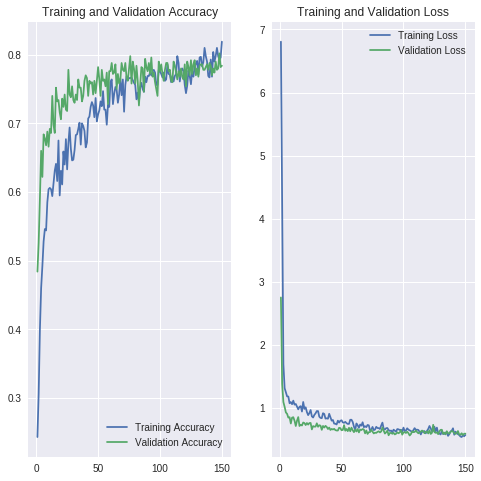

In [0]:
# visualizing the chages in accuracy
acc = history_inception_alt.history['acc']
val_acc = history_inception_alt.history['val_acc']

loss = history_inception_alt.history['loss']
val_loss = history_inception_alt.history['val_loss']

epochs_range = range(1, 150+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Despite allowing it to run a more epochs and adding extra layers to reach the overfitting stage, the accuracies are still close (not significantly different) than the VGG16 model.

How about changing our optimizer and adjusting the layers a little bit more?

In [0]:
# setting up the an adjusted inception model (attempt numner 2)
model_inception_alt2 = Sequential()
model_inception_alt2.add(inception)
model_inception_alt2.add(Flatten())
model_inception_alt2.add(Dense(512, activation='relu')) # got rid of the secondary layer and only kept dropout
model_inception_alt2.add(Dropout(0.5))
model_inception_alt2.add(Dense(5, activation='softmax'))

model_inception_alt2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Now is a good time for a cup of coffee
history_inception_alt2 = model_inception_alt2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=85,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/85
16/16 [==============================] - 4s 280ms/step - loss: 6.7290 - acc: 0.3520
 - 13s - loss: 9.1335 - acc: 0.2590 - val_loss: 6.7290 - val_acc: 0.3520
Epoch 2/85
16/16 [==============================] - 2s 149ms/step - loss: 3.7695 - acc: 0.5660
 - 9s - loss: 6.1052 - acc: 0.4180 - val_loss: 3.7695 - val_acc: 0.5660
Epoch 3/85
16/16 [==============================] - 2s 156ms/step - loss: 1.4322 - acc: 0.7120
 - 10s - loss: 4.2267 - acc: 0.4940 - val_loss: 1.4322 - val_acc: 0.7120
Epoch 4/85
16/16 [==============================] - 3s 161ms/step - loss: 1.6488 - acc: 0.6160
 - 10s - loss: 2.5575 - acc: 0.5460 - val_loss: 1.6488 - val_acc: 0.6160
Epoch 5/85
16/16 [==============================] - 3s 162ms/step - loss: 1.1150 - acc: 0.6580
 - 10s - loss: 1.4813 - acc: 0.5920 - val_loss: 1.1150 - val_acc: 0.6580
Epoch 6/85
16/16 [==============================] - 3s 162ms/step - loss: 0.9138 - acc: 0.7040
 - 10s - loss: 1.2462 - acc: 0.5950 - val_loss: 0.9138 - val_acc: 

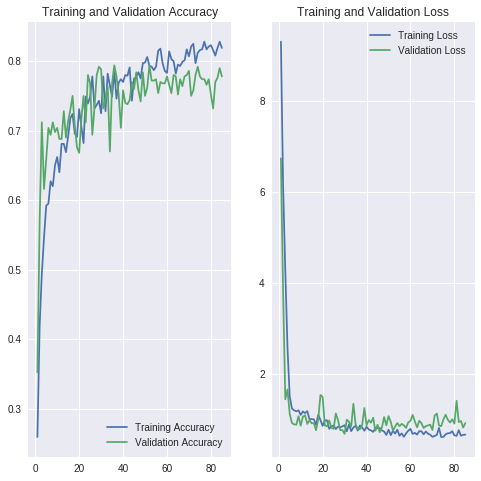

In [0]:
# visualizing the results
acc = history_inception_alt2.history['acc']
val_acc = history_inception_alt2.history['val_acc']

loss = history_inception_alt2.history['loss']
val_loss = history_inception_alt2.history['val_loss']

epochs_range = range(1, 85+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dropping an extra layer actually negatively impacted our model. Nonetheless, the delta is still rather small in relativety.

#### Working with ResNet50

While Inception definitely did not live up to the high execation, perhaps ResNet50 would be a better choice in trying to beat the default performance of VGG16. Let us explore below.

In [0]:
# loading the model
resnet = ResNet50(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
# setting up the model (documentation mentioned how resnet should perform better on massive layers)
model_resnet = Sequential()
model_resnet.add(resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(1024, activation='relu'))
model_resnet.add(Dense(1024, activation='relu'))
model_resnet.add(Dense(5, activation='softmax'))

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
resnet.trainable = False # freezing all layers

In [0]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

# Now is a good time for a cup of coffee
history_resnet = model_resnet.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 6s 374ms/step - loss: 0.6242 - acc: 0.7720
 - 16s - loss: 1.6450 - acc: 0.5510 - val_loss: 0.6242 - val_acc: 0.7720
Epoch 2/50
16/16 [==============================] - 3s 173ms/step - loss: 0.5591 - acc: 0.7960
 - 10s - loss: 0.6494 - acc: 0.7710 - val_loss: 0.5591 - val_acc: 0.7960
Epoch 3/50
16/16 [==============================] - 3s 179ms/step - loss: 0.5662 - acc: 0.8080
 - 11s - loss: 0.5020 - acc: 0.8210 - val_loss: 0.5662 - val_acc: 0.8080
Epoch 4/50
16/16 [==============================] - 3s 174ms/step - loss: 0.5388 - acc: 0.8200
 - 11s - loss: 0.3930 - acc: 0.8640 - val_loss: 0.5388 - val_acc: 0.8200
Epoch 5/50
16/16 [==============================] - 3s 175ms/step - loss: 0.5273 - acc: 0.8460
 - 12s - loss: 0.3854 - acc: 0.8690 - val_loss: 0.5273 - val_acc: 0.8460
Epoch 6/50
16/16 [==============================] - 3s 182ms/step - loss: 0.6792 - acc: 0.8080
 - 12s - loss: 0.3585 - acc: 0.8660 - val_loss: 0.6792 - val_acc:

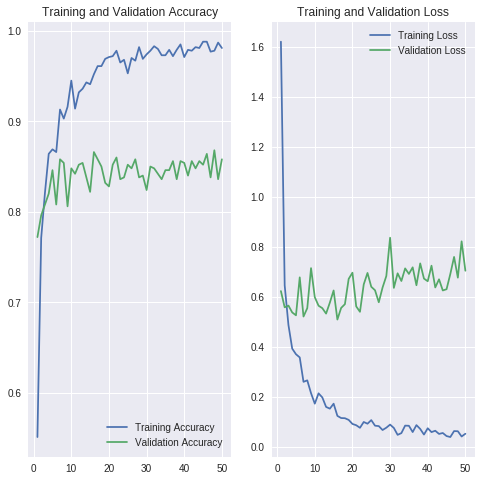

In [0]:
acc = history_resnet.history['acc']
val_acc = history_resnet.history['val_acc']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Very nice! Now we are making progress. Indeed, adding two very big dense layers seem to have done the trick. I wonder if adding another two layers as well as droupout will move the needle even more (perhaps even bring the accuracy to the 90s). Let us see:

In [0]:
# setting up the model (documentation mentioned how resnet should perform better on massive layers)
model_resnet2 = Sequential()
model_resnet2.add(resnet)
model_resnet2.add(Flatten())
model_resnet2.add(Dense(1024, activation='relu'))
model_resnet2.add(Dropout(0.5))
model_resnet2.add(Dense(1024, activation='relu'))
model_resnet2.add(Dropout(0.5))
model_resnet2.add(Dense(512, activation='relu'))
model_resnet2.add(Dropout(0.5))
model_resnet2.add(Dense(5, activation='softmax'))

In [0]:
resnet.trainable = False # freezing all layers

In [0]:
model_resnet2.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

# Now is a good time for a cup of coffee
history_resnet2 = model_resnet2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 6s 360ms/step - loss: 0.7190 - acc: 0.7420
 - 17s - loss: 3.6594 - acc: 0.3350 - val_loss: 0.7190 - val_acc: 0.7420
Epoch 2/50
16/16 [==============================] - 3s 168ms/step - loss: 0.6988 - acc: 0.7340
 - 10s - loss: 1.4963 - acc: 0.4840 - val_loss: 0.6988 - val_acc: 0.7340
Epoch 3/50
16/16 [==============================] - 3s 175ms/step - loss: 0.5611 - acc: 0.7980
 - 11s - loss: 1.1297 - acc: 0.5970 - val_loss: 0.5611 - val_acc: 0.7980
Epoch 4/50
16/16 [==============================] - 3s 172ms/step - loss: 0.5177 - acc: 0.8140
 - 11s - loss: 1.0019 - acc: 0.6390 - val_loss: 0.5177 - val_acc: 0.8140
Epoch 5/50
16/16 [==============================] - 3s 172ms/step - loss: 0.4795 - acc: 0.8260
 - 11s - loss: 0.7988 - acc: 0.6940 - val_loss: 0.4795 - val_acc: 0.8260
Epoch 6/50
16/16 [==============================] - 3s 175ms/step - loss: 0.4809 - acc: 0.8120
 - 11s - loss: 0.8143 - acc: 0.7110 - val_loss: 0.4809 - val_acc:

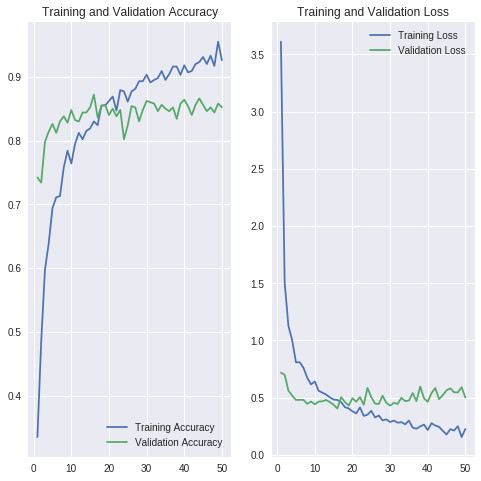

In [0]:
acc = history_resnet2.history['acc']
val_acc = history_resnet2.history['val_acc']

loss = history_resnet2.history['loss']
val_loss = history_resnet2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations from the experiments performed in 1.2
There are a number of interesting findings/patterns that I noticed while applying the models. 

In particular, **when working with Inception** on the flowers classification.

1. Inception needed a few extra layers to catch up with the baseline accuracy established by applying the pre-trained VGG16 model
2. While inception was able to overperform the VGG16 model, the delta is rather small for the amount of "extra work" that needed to be added
3. After testing a number of different optimizations, both Adam and Rmsprop appeared to have the same impact on model performance
4. Since I froze all the layers, making the dense layers larger (going from 216 to 512 etc) made a big difference. I believe this can be explained by the fact that the model is very generic in the state of frozen layers
5. Working with a small dataset of a similar nature (to the original trained imagenet) freezing all the layers was a smart call. In particular, higher-level features are the most relevant.

**When working with ResNet model**:

1. Based on the different readings, I added a number of large generic dense layers into the ResNet model. It seem to have strongly affected the performance pushing it above the 80% benchmark by approximately 5-6%.
2. ResNet did not seem to work with rmsprop optimizer (and even adam) very well on a small number of dense layers as compared to Inception.
3. When assigning SGD optimizer together with more layers the performance of the model has skyrocketed (something I have read about on a related trasnfer learning blog post).
4. With such a broad Dense layer structure, ResNet model did overfit pretty fast (looking at the interception of train and test accuracies on the graph). In comparison, it took inception much longer (granted, the layers there were not as large).
5. Adding Droupout and an additional Dense layer into the model seem to have not had as much effect as anticipated. The model performance was still high but the delta from the previous version turned out to be rather insignificant (may argue that it did more harm than good).

## Part 2: Training a model to recognize landmarks on Columbia’s campus.

### 2.1 Collecting a dataset of at least three landmarks

In [0]:
# starting with dowloading the data for the 4 landmarks
!wget https://storage.googleapis.com/adl-hw2/landmarks.zip -O /tmp/landmarks.zip

--2019-03-05 04:10:18--  https://storage.googleapis.com/adl-hw2/landmarks.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2255560975 (2.1G) [application/zip]
Saving to: ‘/tmp/landmarks.zip’

/tmp/landmarks.zip  100%[===================>]   2.10G  69.9MB/s    in 35s     

2019-03-05 04:10:54 (61.0 MB/s) - ‘/tmp/landmarks.zip’ saved [2255560975/2255560975]



In [0]:
# unzipping the file
local_zip = '/tmp/landmarks.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# checking the landmarks we would be working with
!ls /tmp/landmarks

Bust  Hamilton	Jefferson  Lion


We will be working with the data collected for the statues of Hamilton, Jefferson, Lion, and the Bust. I did not capture name of the last one, my bad:(

In [0]:
# creating directory paths

base_dir = '/tmp/landmarks'

bust_dir = os.path.join(base_dir, 'Bust')
hamilton_dir = os.path.join(base_dir, 'Hamilton')
jefferson_dir = os.path.join(base_dir, 'Jefferson')
lion_dir = os.path.join(base_dir, 'Lion')

In [0]:
# exploring the dataset
num_bust = len(os.listdir(bust_dir))
num_hamilton = len(os.listdir(hamilton_dir))
num_jefferson = len(os.listdir(jefferson_dir))
num_lion = len(os.listdir(lion_dir))

total_num = num_bust + num_hamilton + num_jefferson + num_lion

print('Number of Bust images:', num_bust)
print('Number of Hamilton images:', num_hamilton)
print('Number of Jefferson images:', num_jefferson)
print('Number of Lion images:', num_lion)

print("--")

print("Total number of images:", total_num)

Number of Bust images: 169
Number of Hamilton images: 239
Number of Jefferson images: 173
Number of Lion images: 179
--
Total number of images: 760


In [0]:
# rescaling images
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 150 
BATCH_SIZE = 32
image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=base_dir, 
                                                     shuffle=True, # Best practice: shuffle the data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='categorical')

sample_images, sample_labels = next(data_gen)

Found 756 images belonging to 4 classes.


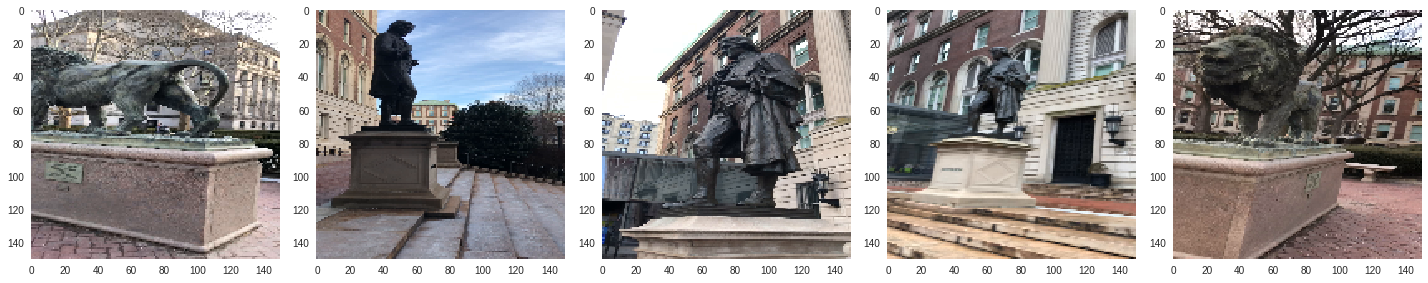

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
plotImages(sample_images[20:25])

### 2.2 Writing a model to classify collected dataset using transfer learning.

Let us use VGG16 based on our experience working with it on the flower classification. We are just going to use the caching shortcut.

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

features, labels = extract_features(base_dir, 756)

Found 756 images belonging to 4 classes.


In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

features = np.reshape(features, (756, FLATTENED_SHAPE))

In [0]:
# perform a train/val/test split
# randomly shuffle the images in the dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(features, labels, test_size=0.15, random_state=41)
# add validation split into the train subsample
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.33, random_state=41)

In [0]:
EPOCHS = 30

model_vgg = Sequential()
model_vgg.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(4, activation='softmax'))

model_vgg.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_vgg = model_vgg.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val))

Train on 430 samples, validate on 212 samples
Epoch 1/30
430/430 [==============================] - 3s 6ms/sample - loss: 1.7886 - acc: 0.2465 - val_loss: 9.5946 - val_acc: 0.3443
Epoch 2/30
430/430 [==============================] - 0s 137us/sample - loss: 10.1327 - acc: 0.3023 - val_loss: 10.8186 - val_acc: 0.2547
Epoch 3/30
430/430 [==============================] - 0s 119us/sample - loss: 10.2302 - acc: 0.2233 - val_loss: 1.4702 - val_acc: 0.4953
Epoch 4/30
430/430 [==============================] - 0s 123us/sample - loss: 2.0394 - acc: 0.5186 - val_loss: 1.8572 - val_acc: 0.6132
Epoch 5/30
430/430 [==============================] - 0s 124us/sample - loss: 2.8012 - acc: 0.4837 - val_loss: 0.4904 - val_acc: 0.7594
Epoch 6/30
430/430 [==============================] - 0s 128us/sample - loss: 0.6279 - acc: 0.7628 - val_loss: 1.2751 - val_acc: 0.7075
Epoch 7/30
430/430 [==============================] - 0s 125us/sample - loss: 1.2845 - acc: 0.7116 - val_loss: 2.7555 - val_acc: 0.5708
E

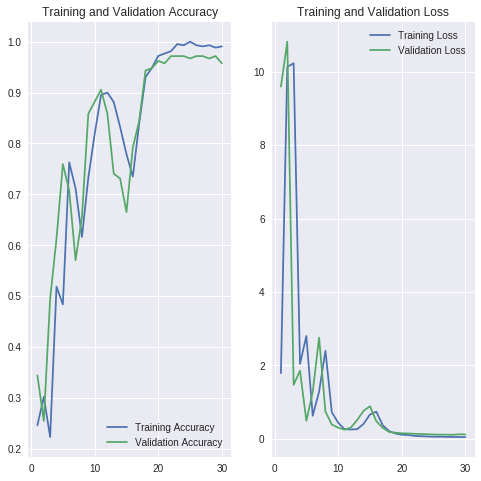

In [0]:
acc = history_vgg.history['acc']
val_acc = history_vgg.history['val_acc']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It looks like the dataset is actually showing great results when classifying that way! Since it looks like the model is already doing a great job, perhaps using a simple manual model will be good enough? Let us try and see!

In [0]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 1285      
Total params: 2,098,693
Trainable params: 2,098,693
Non-trainable params: 0
_________________________________________________________________


It is important to mention that looking at the model summary, it is already pretty simple:)

### 2.3 Experimenting with different models to find the best balance between accuracy and complexity.

In [0]:
# building a very simple model from stratch (going for the smallest model possible)
model_manual = Sequential()
model_manual.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_manual.add(MaxPooling2D((2, 2)))
model_manual.add(Conv2D(64, (3, 3), activation='relu'))
model_manual.add(MaxPooling2D((2, 2)))
model_manual.add(Conv2D(128, (3, 3), activation='relu'))
model_manual.add(MaxPooling2D((2, 2)))
model_manual.add(Flatten())
model_manual.add(Dense(512, activation='relu'))
model_manual.add(Dense(4, activation='softmax'))

model_manual.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 36992)             0         
__________

In [0]:
# Cache activations for our training and validation data
data_gen = image_generator.flow_from_directory(batch_size=756, 
                                                     directory=base_dir, 
                                                     shuffle=True, # Best practice: shuffle the data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='categorical')

features, labels = next(data_gen)

Found 756 images belonging to 4 classes.


In [0]:
# perform a train/val/test split
# randomly shuffle the images in the dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(features, labels, test_size=0.15, random_state=41)
# add validation split into the train subsample
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.33, random_state=41)

In [0]:
model_manual.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_manual = model_manual.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val))

Train on 430 samples, validate on 212 samples
Epoch 1/30
430/430 [==============================] - 7s 17ms/sample - loss: 1.3811 - acc: 0.2791 - val_loss: 7.3461 - val_acc: 0.3113
Epoch 2/30
430/430 [==============================] - 1s 2ms/sample - loss: 6.8630 - acc: 0.3047 - val_loss: 3.5653 - val_acc: 0.1698
Epoch 3/30
430/430 [==============================] - 1s 2ms/sample - loss: 3.1486 - acc: 0.2581 - val_loss: 1.9803 - val_acc: 0.2358
Epoch 4/30
430/430 [==============================] - 1s 2ms/sample - loss: 1.9356 - acc: 0.2442 - val_loss: 1.5919 - val_acc: 0.2594
Epoch 5/30
430/430 [==============================] - 1s 2ms/sample - loss: 1.6075 - acc: 0.2628 - val_loss: 1.3984 - val_acc: 0.3349
Epoch 6/30
430/430 [==============================] - 1s 2ms/sample - loss: 1.4108 - acc: 0.3349 - val_loss: 1.3268 - val_acc: 0.4292
Epoch 7/30
430/430 [==============================] - 1s 2ms/sample - loss: 1.3189 - acc: 0.4837 - val_loss: 1.3507 - val_acc: 0.3113
Epoch 8/30
430/

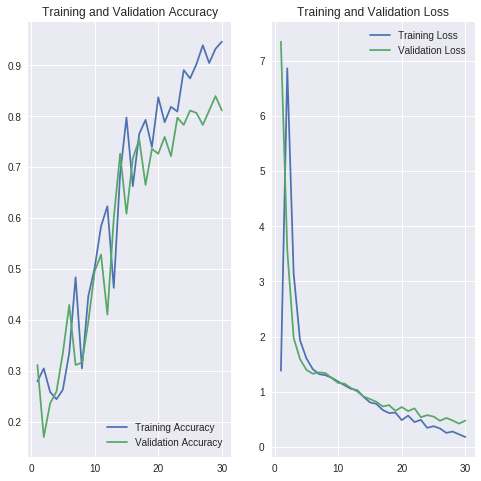

In [0]:
acc = history_manual.history['acc']
val_acc = history_manual.history['val_acc']

loss = history_manual.history['loss']
val_loss = history_manual.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Interesting! It is still doing ok with the manual implementation. Lastly, let us try a very simple model.

In [0]:
model_manual2 = Sequential()
model_manual2.add(Flatten())
model_manual2.add(Dense(1024, activation='relu'))
model_manual2.add(Dense(516, activation='relu'))
model_manual2.add(Dense(516, activation='relu'))
model_manual2.add(Dense(214, activation='relu'))
model_manual2.add(Dense(4, activation='softmax'))

In [0]:
model_manual2.compile(optimizer='SGD', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_manual2 = model_manual2.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val))

Train on 430 samples, validate on 212 samples
Epoch 1/30
430/430 [==============================] - 3s 7ms/sample - loss: 1.4607 - acc: 0.2465 - val_loss: 1.4004 - val_acc: 0.3113
Epoch 2/30
430/430 [==============================] - 0s 561us/sample - loss: 1.4616 - acc: 0.3047 - val_loss: 1.5420 - val_acc: 0.1698
Epoch 3/30
430/430 [==============================] - 0s 551us/sample - loss: 1.4721 - acc: 0.2581 - val_loss: 1.4479 - val_acc: 0.2217
Epoch 4/30
430/430 [==============================] - 0s 515us/sample - loss: 1.4406 - acc: 0.2256 - val_loss: 1.5324 - val_acc: 0.1698
Epoch 5/30
430/430 [==============================] - 0s 533us/sample - loss: 1.4862 - acc: 0.2581 - val_loss: 1.3257 - val_acc: 0.3160
Epoch 6/30
430/430 [==============================] - 0s 512us/sample - loss: 1.3858 - acc: 0.3023 - val_loss: 1.3912 - val_acc: 0.2736
Epoch 7/30
430/430 [==============================] - 0s 527us/sample - loss: 1.3066 - acc: 0.3395 - val_loss: 1.2640 - val_acc: 0.4575
Epoc

All in all, it looks like we do not need a very crazy dense multi-layer model in order to achieve good results on our small dataset. Using the caching trick with the VGG16 approach already seems to do the magic. When experimenting with extremes of only applying one or two layers after flattening, the model performance was dropping quite significantly however (important to mention that there is a limit to proposed simplicity)